# Chair GAN experiment

In [1]:
# Setup
checkpoints_path = '/Users/alukasik/Documents/IDEO/Developer/checkpoints/chairs-30-5-18/checkpoint.ckpt'
batch_size = 64 # must match batch size of saved session
img_shape = (256, 256)
zsize = 16 # number of variables for "genome"

In [2]:
# imports

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math


from utils import pixels01, pixels11
from model import Model as M

/anaconda3/envs/chairs/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
savechair = []
incorrectchair = []

In [4]:
def imshow(imgs, cols=4):
    fig = plt.figure(figsize=(15,8))
    nimgs = len(imgs)
    rows = math.ceil(float(nimgs)/cols) 
    row = 0
    for i in range(nimgs):
        a=fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

In [5]:
model = M(None, batch_size=batch_size, img_shape=img_shape, checkpoints_path=checkpoints_path, zsize=zsize)

model.build_model()
model.setup_session()

trying to restore session from /Users/alukasik/Documents/IDEO/Developer/checkpoints/chairs-30-5-18/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from /Users/alukasik/Documents/IDEO/Developer/checkpoints/chairs-30-5-18/checkpoint.ckpt
restored session


Above is setup to restore the GAN session from a checkpoint and prepare the model for generating outputs.

The arrays "savechair" and "incorrectchair" are initialized above as well.

Currently the zsize is 16, this parameter is may change deoending on the types of experiments being run.

Below is raw output of the GAN. Run this to generate chairs as many times as you like. It is currently only displaying 16 outputs at a time but the model creates 64 each time it is run. Only 16 are displayed becuase it is easier to read this at a glance.

[-0.4766578  -2.8488998   1.6462936   0.49903524  1.2616537   0.25611776
  0.19077195 -1.8251678   0.8468062  -1.5222602  -0.27471232 -0.2898535
 -0.08148816 -1.6696863   0.5979368   0.6922105 ]


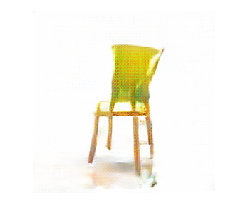

In [15]:
zdraw = np.random.normal(scale=1.0, size=(batch_size, zsize)).astype('float32')
imgs = pixels01(model.Gz.eval({ model.Z: zdraw, model.is_training: False }))
imshow(imgs[:1])
# img = imgs[0,:,:,:]
print(zdraw[0,:])

[-0.48 -2.85  1.65  0.5   1.26  0.26  0.19 -1.83  0.85 -1.52 -0.27 -0.29
 -0.08 -1.67  0.6   0.69]


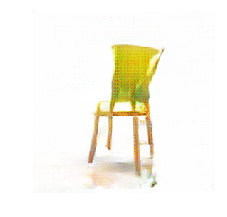

In [18]:
rounded = np.round(zdraw, 2)
print(rounded[0,:])
imgs = pixels01(model.Gz.eval({ model.Z: rounded, model.is_training: False }))
imshow(imgs[:1])

Below are two cells that append the arrays "savechair" and "incorrectchair" with outputs from the raw GAN above. You may append these arrays by changing the integer in the append function to correlate with a chair from left to right top to bottom, 0-15

In [7]:
savechair.append(zdraw[3,:])
savechair.append(zdraw[6,:])

In [8]:
incorrectchair.append(zdraw[5,:])

Below are two cells, the first clears the "savechair" and "incorrectchair" arrays. 

The second loads a csv into an array called "diskchairs" this is used to bring back old save chair arrays from previous experiments. Please be aware that the file name "chairs.csv" is a place holder, it is advised you create dated savechair files on the disk

These are always commented out unless needed

In [9]:
savechair = []
# incorrectchair = []

In [10]:
# diskchairs = np.loadtxt("chairs.csv", delimiter=",")

Below is a cell that combines the vectors of zdraw[2] (chair 3) and zdraw[5] (chair 6) and displays the output as zdraw[0] (chair 1)

In [11]:
zdraw[0] = (savechair[0] + savechair[1]) / 2
#addition of the the 2nd image and 5th image
imgs = pixels01(model.Gz.eval({ model.Z: zdraw, model.is_training: False }))
imshow(imgs[:1])

IndexError: list index out of range

Below is a cell that inverts the vector of the zdraw[5] (chair 6) and displays the output as zdraw[0] (chair 1)

In [ ]:
zdraw[0] = -zdraw[0]
imgs = pixels01(model.Gz.eval({ model.Z: zdraw, model.is_training: False }))
imshow(imgs[:1])


# Below are experiments that specifically deal with the array "savechair"

The two cells below display the contents of the arrays "savechair" and "incorrectchair"

In [ ]:
imgs = pixels01(model.Gz.eval({ model.Z: savechair, model.is_training: False }))
imshow(imgs[:8])

In [ ]:
imgs = pixels01(model.Gz.eval({ model.Z: incorrectchair, model.is_training: False }))
imshow(imgs[:8])

The cell below it built to create a stepped interpolation between two chairs, in this case savechair[1] and savechair[0]. The way this works is a varriable is created called "n_interps" which is the number of steps that will be created between the two chairs. This is then passed into a simple equation that creates a "delta" of the two vectors of the interpolation steps. All of this is then utilized in a for loop with interpolated steps walking through the each step in realtion to the delta and is output as "interpolated".

In [ ]:
n_interps = 12
delta = (savechair[1] - savechair[0]) / n_interps
interpolated = np.zeros((n_interps+1, 16))
interpolated[0,:] = savechair[0]
for i in range(n_interps-1):
    interpolated[i+1,:] = interpolated[i,:] + delta


interpolated[-1,:] = savechair[1]

"interploated" is displayed below

In [ ]:
imgs = pixels01(model.Gz.eval({ model.Z: interpolated, model.is_training: False }))
imshow(imgs[:12])

In the cell below an array named "varried" is created using savechair[1], with the parameters inside being randomized on a scale. This is then displayed after.

In [ ]:
varied = savechair[1] + np.random.normal(scale=0.6, size=(8, 16)).astype('float32')
varied[0,1] = 0
imgs = pixels01(model.Gz.eval({ model.Z: varied, model.is_training: False }))
imshow(imgs[:12])

Below is a cell that examines the standard deviation across all the parameters of all chairs in the array "savechair". This is doen in order to highlight what parameters are very siumilar among visually similar chairs. Currently this graph dispalys only 16 parameters which correlates to the number of parameters used during this instance of training the GAN. This graph is used in this notebook to then select which parameters to fix (in the context of just one chair's parameters being fixed) so as to explore the potential "meaning" of those parameters in the GAN.

The cell that follows simply saves and prints what parameters deviate below a certian varriance.

In [ ]:
savechairmatrix = np.array(savechair)
savechairmatrix.shape
stds = np.std(savechairmatrix, axis=0)

sns.set_style("white")
sns.set_color_codes("pastel")
sns.set(font_scale=2)

labels = list(range(stds.size))

sns.barplot(x=labels, y=stds, color="b")
sns.despine()

In [ ]:
indices = np.where(stds < 0.2)
indices

In the cell below a new array named "biased_zdraw" is created that will be used to render chairs with some parameters fixed based of off what parameters are saved in the above array "indices". 

In order to contain the the changes maded during this process a temporary "savechair" array is made named "_savechair". These are then used in a for loop to step through the indices that are ment to be fixed and isolate them. The output of this is an appended "biased_zdraw" which is then rendered.

The cell that follows allows you to then save outputs from this to the global array "savechair" for further experimentation.

In [ ]:
biased_zdraw = np.random.normal(scale=1.0, size=(batch_size, 16)).astype('float32')
_savechair = np.array(savechair)
for i in np.nditer(indices):
    biased_zdraw[:,i] = _savechair[0,i]

imgs = pixels01(model.Gz.eval({ model.Z: biased_zdraw, model.is_training: False }))
imshow(imgs[:8])


In [ ]:
savechair.append(biased_zdraw[2,:])

Below is the cell that allows for the global array "savechair" to be saved to disk. Only uncomment on use. Please be aware that the file name "chairs.csv" is a place holder, it is advised you create dated savechair files on the disk.

In [ ]:
# np.savetxt("chairs.csv", savechair, delimiter=",")

In this final experiment we introduce the array "masterchair" which is used to isolate one specific chair to be itterated upon by the GAN. 

##### The first cell in this experiment should be commented out after it is run as to not accidentally clear the array "masterchair". 

This cell clears the array and then adds one chair to it from the global array "savechair".

In [ ]:
masterchair = []
masterchair.append(savechair[0])

The final two cells iterate on "masterchair" through differnt means.

The first steps through each of the 16 paramters and sets each one to 0 one at a time. Then the 16 varriations of the chair are rendered. This is done in the for loop and in the loop the array "diffchair" is created. 

The second is designed to isolate any one of the 16 parameters, in this case the 4th (diffchair[3]) and 7th (diffchair[6]) parameters and then setting them to 0. Then append them to the global array "savechair" and display them.

In [ ]:
for i in range(zsize):
    diffchair = np.array(masterchair[0])
    diffchair[i] = 0
    savechair.append(diffchair)

imgs = pixels01(model.Gz.eval({ model.Z: savechair, model.is_training: False }))
imshow(imgs[:16])

In [ ]:
diffchair = np.array(masterchair[0])
diffchair[3] = 0
diffchair[6] = 0
savechair.append(diffchair)

imgs = pixels01(model.Gz.eval({ model.Z: savechair, model.is_training: False }))
imshow(imgs[:8])